# Track model training in notebooks with MLflow

You can use MLflow in a notebook to track any models you train. As you'll run this notebook with an Azure Machine Learning compute instance, you don't need to set up MLflow: it's already installed and integrated. 

You'll prepare some data and train a model to predict diabetes. You'll use autologging, and custom logging to explore how you can use MLflow in notebooks.

## Before you start

You'll need the latest version of the **azure-ai-ml** package to run the code in this notebook. Run the cell below to verify that it is installed.

> **Note**:
> If the **azure-ai-ml** package is not installed, run `pip install azure-ai-ml` to install it.

In [1]:
pip show azure-ai-ml

Name: azure-ai-ml
Version: 1.19.0
Summary: Microsoft Azure Machine Learning Client Library for Python
Home-page: https://github.com/Azure/azure-sdk-for-python
Author: Microsoft Corporation
Author-email: azuresdkengsysadmins@microsoft.com
License: MIT License
Location: /anaconda/envs/azureml_py38/lib/python3.9/site-packages
Requires: azure-common, azure-core, azure-mgmt-core, azure-storage-blob, azure-storage-file-datalake, azure-storage-file-share, colorama, isodate, jsonschema, marshmallow, msrest, opencensus-ext-azure, opencensus-ext-logging, pydash, pyjwt, pyyaml, strictyaml, tqdm, typing-extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


## Connect to your workspace

With the required SDK packages installed, now you're ready to connect to your workspace.

To connect to a workspace, we need identifier parameters - a subscription ID, resource group name, and workspace name. Since you're working with a compute instance, managed by Azure Machine Learning, you can use the default values to connect to the workspace.

In [2]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [3]:
# Get a handle to workspace
ml_client = MLClient.from_config(credential=credential)

Found the config file in: /config.json


## Configure MLflow

As you're running this notebook on a compute instance in the Azure Machine Learning studio, you don't need to configure MLflow. 

Still, it's good to verify that the necessary library is indeed installed.

> **Note**:
> If the **mlflow** library is not installed, run `pip install mlflow` to install it.

In [4]:
pip show mlflow

Name: mlflow
Version: 2.15.1
Summary: MLflow is an open source platform for the complete machine learning lifecycle
Home-page: 
Author: 
Author-email: 
License: Copyright 2018 Databricks, Inc.  All rights reserved.
        
                                        Apache License
                                   Version 2.0, January 2004
                                http://www.apache.org/licenses/
        
           TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION
        
           1. Definitions.
        
              "License" shall mean the terms and conditions for use, reproduction,
              and distribution as defined by Sections 1 through 9 of this document.
        
              "Licensor" shall mean the copyright owner or entity authorized by
              the copyright owner that is granting the License.
        
              "Legal Entity" shall mean the union of the acting entity and all
              other entities that control, are controlled by, 

## Prepare the data

You'll train a diabetes classification model. The training data is stored in the **data** folder as **diabetes.csv**. 

First, let's read the data:

In [6]:
import pandas as pd

print("Reading data...")
df = pd.read_csv('./data/diabetes.csv')
df.head()

Reading data...


,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


Next, you'll split the data into features and the label (Diabetes):

In [7]:
print("Splitting data...")
X, y = df[['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']].values, df['Diabetic'].values

Splitting data...


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

You now have four dataframes:

- `X_train`: The training dataset containing the features.
- `X_test`: The test dataset containing the features.
- `y_train`: The label for the training dataset.
- `y_test`: The label for the test dataset.

You'll use these to train and evaluate the models you'll train.

## Create an MLflow experiment

Now that you're ready to train machine learning models, you'll first create an MLflow experiment. By creating the experiment, you can group all runs within one experiment and make it easier to find the runs in the studio.

In [9]:
import mlflow
experiment_name = "mlflow-experiment-diabetes"
mlflow.set_experiment(experiment_name)

2024/08/16 06:31:51 INFO mlflow.tracking.fluent: Experiment with name 'mlflow-experiment-diabetes' does not exist. Creating a new experiment.


<Experiment: artifact_location='', creation_time=1723789911873, experiment_id='06172f1b-0794-4170-a26f-7350eab418ea', last_update_time=None, lifecycle_stage='active', name='mlflow-experiment-diabetes', tags={}>

## Train and track models

To track a model you train, you can use MLflow and enable autologging. The following cell will train a classification model using logistic regression. You'll notice that you don't need to calculate any evaluation metrics because they're automatically created and logged by MLflow.

In [10]:
from sklearn.linear_model import LogisticRegression

with mlflow.start_run():
    mlflow.sklearn.autolog()

    model = LogisticRegression(C=1/0.1, solver="liblinear").fit(X_train, y_train)


2024/08/16 06:32:22 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpnqead7dl/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.1.3', 'cloudpickle==1.6.0']. Set logging level to DEBUG to see the full traceback. 
2024/08/16 06:32:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py38/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2024/08/16 06:32:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run nice_brush_y02rd6xv at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/0b55cd57-b045-4554-a808-6be858a04b64/resourceGroups/rg-dp100-lce53214446da4c68be/providers/Microsoft.MachineLearningServices/workspaces/mlw-dp100-lce53214446da4c68be/#/experiments/06172f1b-0794-4170-a26f-7350eab418ea/runs/783e70b0-38f5-42e1-acbb-fe5586d5980f.
2024/08/16 06:32:25 INFO mlflow.track

You can also use custom logging with MLflow. You can add custom logging to autologging, or you can use only custom logging.

Let's train two more models with scikit-learn. Since you ran the `mlflow.sklearn.autolog()` command before, MLflow will now automatically log any model trained with scikit-learn. To disable the autologging, run the following cell:

In [11]:
mlflow.sklearn.autolog(disable=True)

Now, you can train and track models using only custom logging. 

When you run the following cell, you'll only log one parameter and one metric.

In [12]:
from sklearn.linear_model import LogisticRegression
import numpy as np

with mlflow.start_run():
    model = LogisticRegression(C=1/0.1, solver="liblinear").fit(X_train, y_train)

    y_hat = model.predict(X_test)
    acc = np.average(y_hat == y_test)

    mlflow.log_param("regularization_rate", 0.1)
    mlflow.log_metric("Accuracy", acc)

2024/08/16 06:32:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run olive_spring_9fb5q728 at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/0b55cd57-b045-4554-a808-6be858a04b64/resourceGroups/rg-dp100-lce53214446da4c68be/providers/Microsoft.MachineLearningServices/workspaces/mlw-dp100-lce53214446da4c68be/#/experiments/06172f1b-0794-4170-a26f-7350eab418ea/runs/722b301d-8c06-479e-8766-8247f2da8a9b.
2024/08/16 06:32:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/0b55cd57-b045-4554-a808-6be858a04b64/resourceGroups/rg-dp100-lce53214446da4c68be/providers/Microsoft.MachineLearningServices/workspaces/mlw-dp100-lce53214446da4c68be/#/experiments/06172f1b-0794-4170-a26f-7350eab418ea.


The reason why you'd want to track models, could be to compare the results of models you train with different hyperparameter values. 

For example, you just trained a logistic regression model with a regularization rate of 0.1. Now, train another model, but this time with a regularization rate of 0.01. Since you're also tracking the accuracy, you can compare and decide which rate results in a better performing model.

In [13]:
from sklearn.linear_model import LogisticRegression
import numpy as np

with mlflow.start_run():
    model = LogisticRegression(C=1/0.01, solver="liblinear").fit(X_train, y_train)

    y_hat = model.predict(X_test)
    acc = np.average(y_hat == y_test)

    mlflow.log_param("regularization_rate", 0.01)
    mlflow.log_metric("Accuracy", acc)

2024/08/16 06:33:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run olden_piano_88cthns9 at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/0b55cd57-b045-4554-a808-6be858a04b64/resourceGroups/rg-dp100-lce53214446da4c68be/providers/Microsoft.MachineLearningServices/workspaces/mlw-dp100-lce53214446da4c68be/#/experiments/06172f1b-0794-4170-a26f-7350eab418ea/runs/d91722c0-c845-48f3-b17b-a8f217852107.
2024/08/16 06:33:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/0b55cd57-b045-4554-a808-6be858a04b64/resourceGroups/rg-dp100-lce53214446da4c68be/providers/Microsoft.MachineLearningServices/workspaces/mlw-dp100-lce53214446da4c68be/#/experiments/06172f1b-0794-4170-a26f-7350eab418ea.


Another reason to track your model's results is when you're testing another estimator. All models you've trained so far used the logistic regression estimator. 

Run the following cell to train a model with the decision tree classifier estimator and review whether the accuracy is higher compared to the other runs.

In [14]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

with mlflow.start_run():
    model = DecisionTreeClassifier().fit(X_train, y_train)

    y_hat = model.predict(X_test)
    acc = np.average(y_hat == y_test)

    mlflow.log_param("estimator", "DecisionTreeClassifier")
    mlflow.log_metric("Accuracy", acc)

2024/08/16 06:33:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run polite_garlic_j61fd3bv at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/0b55cd57-b045-4554-a808-6be858a04b64/resourceGroups/rg-dp100-lce53214446da4c68be/providers/Microsoft.MachineLearningServices/workspaces/mlw-dp100-lce53214446da4c68be/#/experiments/06172f1b-0794-4170-a26f-7350eab418ea/runs/5f5b35b3-cd2e-4081-8664-ba9ad8489807.
2024/08/16 06:33:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/0b55cd57-b045-4554-a808-6be858a04b64/resourceGroups/rg-dp100-lce53214446da4c68be/providers/Microsoft.MachineLearningServices/workspaces/mlw-dp100-lce53214446da4c68be/#/experiments/06172f1b-0794-4170-a26f-7350eab418ea.


Finally, let's try to log an artifact. An artifact can be any file. For example, you can plot the ROC curve and store the plot as an image. The image can be logged as an artifact. 

Run the following cell to log a parameter, metric, and an artifact.

2024/08/16 06:33:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run stoic_lettuce_qqzmn7bz at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/0b55cd57-b045-4554-a808-6be858a04b64/resourceGroups/rg-dp100-lce53214446da4c68be/providers/Microsoft.MachineLearningServices/workspaces/mlw-dp100-lce53214446da4c68be/#/experiments/06172f1b-0794-4170-a26f-7350eab418ea/runs/7a1121d8-e07b-4db5-bd7a-1fc573474211.
2024/08/16 06:33:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/0b55cd57-b045-4554-a808-6be858a04b64/resourceGroups/rg-dp100-lce53214446da4c68be/providers/Microsoft.MachineLearningServices/workspaces/mlw-dp100-lce53214446da4c68be/#/experiments/06172f1b-0794-4170-a26f-7350eab418ea.


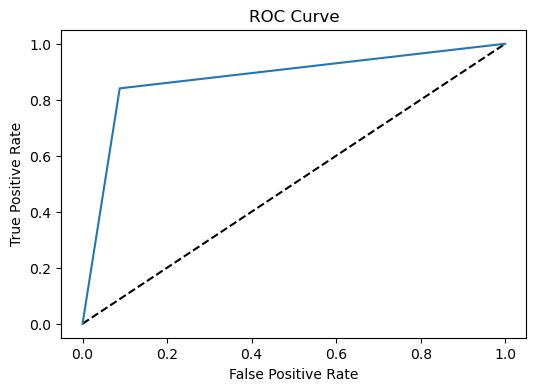

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np

with mlflow.start_run():
    model = DecisionTreeClassifier().fit(X_train, y_train)

    y_hat = model.predict(X_test)
    acc = np.average(y_hat == y_test)

    # plot ROC curve
    y_scores = model.predict_proba(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
    fig = plt.figure(figsize=(6, 4))
    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], 'k--')
    # Plot the FPR and TPR achieved by our model
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.savefig("ROC-Curve.png")

    mlflow.log_param("estimator", "DecisionTreeClassifier")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_artifact("ROC-Curve.png")

Review the model's results on the Jobs page of the Azure Machine Learning studio. 

- You'll find the parameters under **Params** in the **Overview** tab.
- You'll find the metrics under **Metrics** in the **Overview** tab, and in the **Metrics** tab.
- You'll find the artifacts in the **Outputs + logs** tab.

![Screenshot of outputs and logs tab on the Jobs page.](./images/output-logs.png)